# ARIMA - RANDOM FOREST - XGBOOST
DataSet: CO2 emission(https://www.kaggle.com/datasets/thedevastator/global-fossil-co2-emissions-by-country-2002-2022)

In this notebook i used three diferents ML models trying to predict CO2 emission in the world.

In [1]:
#Importing libraries

#General libraries
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

#tools
from itertools import product
from tqdm import tqdm_notebook
# No Warnings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [100]:
#Importing DataSet from local

co2_ts = pd.read_csv('C:/Users/ecolg/Python/Proyecto Pandas/Datos/co2-forecasting.csv')
co2_ts.head()

,country,abreviation_country,year,total,coal,oil,gas,cement,flaring,other,per_capita
0,Afghanistan,AFG,1750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,AFG,1751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,AFG,1752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,AFG,1753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,AFG,1754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Grouping by year and total mean.

co2_year = co2_ts.groupby(by = ['year'], as_index=False)['total'].mean()
co2_year.sample(5)

,year,total
175,1925,16.632307
220,1970,64.552767
158,1908,12.394662
145,1895,6.630681
11,1761,0.048990


In [4]:
#Stadistics from DF
print(co2_year.shape)
co2_year.describe()

(272, 2)


,year,total
count,272.000000,272.000000
mean,1885.500000,27.792665
std,78.663842,43.814181
min,1750.000000,0.041743
25%,1817.750000,0.221386
50%,1885.500000,4.542738
75%,1953.250000,29.105324
max,2021.000000,161.170094


In [5]:
#Verifiying data types
co2_year.dtypes

year       int64
total    float64
dtype: object

In [6]:
#co2_year.reset_index(inplace=True, drop= True)

<AxesSubplot:xlabel='year', ylabel='total'>

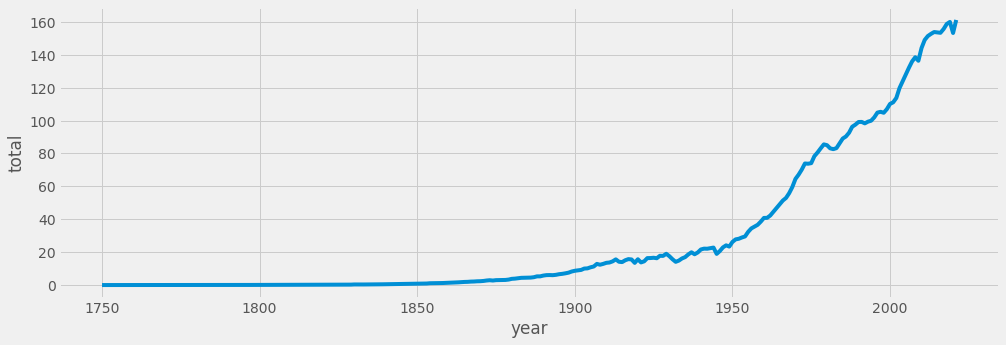

In [7]:
#Data ploting
plt.figure(figsize=(15,5))
sns.lineplot(data=co2_year, x="year", y="total")

In [8]:
# "Year" shoulb be Datatime type.

In [9]:
#last 10 rows
co2_year.tail(10)

,year,total
262,2012,151.390013
263,2013,152.714941
264,2014,153.839600
265,2015,153.572192
266,2016,153.363446
267,2017,155.652823
268,2018,158.731321
269,2019,159.968753
270,2020,153.239183
271,2021,161.170094


From the graph above (cell 7), we decided to use data since 1900

In [10]:
co2_year = co2_year[co2_year['year'] > 1900]
co2_year.head()

,year,total
151,1901,9.003324
152,1902,9.230732
153,1903,10.062924
154,1904,10.177450
155,1905,10.836220


<AxesSubplot:xlabel='year', ylabel='total'>

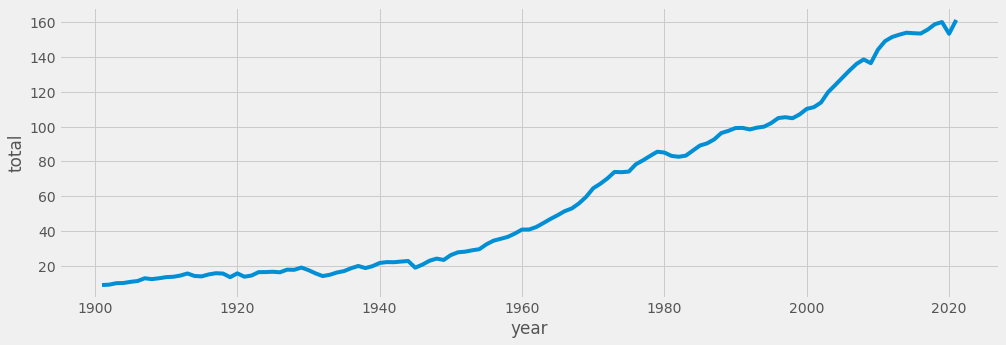

In [11]:
#Data ploting since 1900
plt.figure(figsize=(15,5))
sns.lineplot(data=co2_year, x="year", y="total")

In [12]:
#covert year column to DateTime and set as index
co2_f = co2_year.copy()
co2_f['year'] = pd.to_datetime(co2_f['year'], format = "%Y")
co2_f = co2_f.set_index('year')

In [13]:
# Make sure that index is DatetimeIndex named "date"
if isinstance(co2_f.index, pd.DatetimeIndex):
    co2_f.index.name = 'date'
else:
    co2_f.rename(columns={'index':'date'}, inplace=True)
    co2_f.set_index('date', inplace=True)
    
co2_f

,total
date,
1901-01-01,9.003324
1902-01-01,9.230732
1903-01-01,10.062924
1904-01-01,10.177450
1905-01-01,10.836220
...,...
2017-01-01,155.652823
2018-01-01,158.731321
2019-01-01,159.968753


In [14]:
# The 'YS' string groups the data in buckets by start of the year
co2_f = co2_f.asfreq('YS')
co2_f

,total
date,
1901-01-01,9.003324
1902-01-01,9.230732
1903-01-01,10.062924
1904-01-01,10.177450
1905-01-01,10.836220
...,...
2017-01-01,155.652823
2018-01-01,158.731321
2019-01-01,159.968753


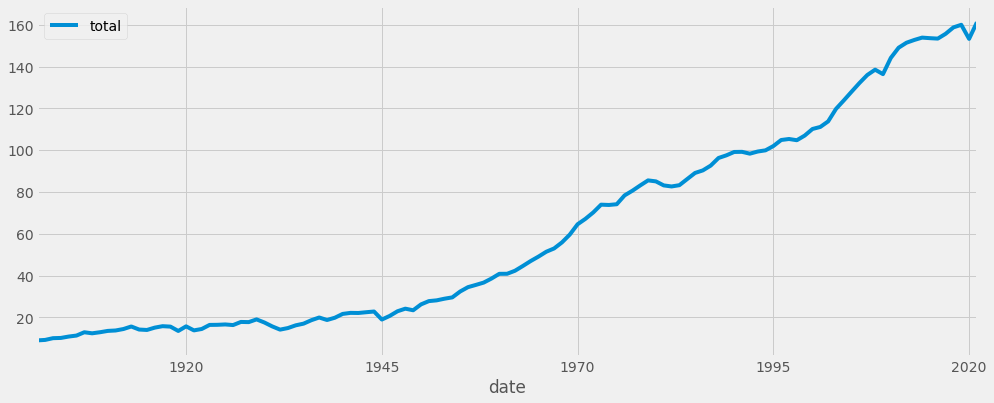

                total
date                 
1901-01-01   9.003324
1902-01-01   9.230732
1903-01-01  10.062924
1904-01-01  10.177450
1905-01-01  10.836220


In [15]:
# Plot the time series
co2_f.plot(figsize=(15, 6))
plt.show()
print(co2_f.head())

### Auto Correlation function (ACF) and Partial Autocorrelation Funcion(PACF).
 Graphing the PACF and ACF to see data behavior

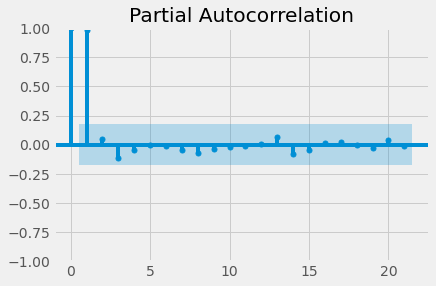

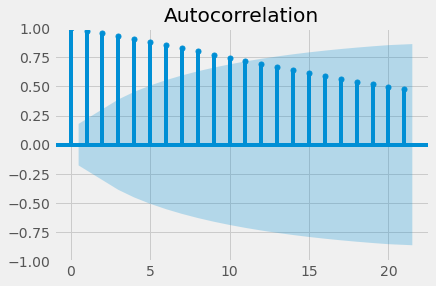

In [16]:
plot_pacf(co2_f['total']);
plot_acf(co2_f['total']);

Before to use ARIMA model we need to know the stacionality, we use Augmented Dickey Fuller test to know.

In [111]:
#Function to know stacionality

def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios (Stationary)")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos son no estacionarios (Non Stationary)")

In [112]:
Prueba_Dickey_Fuller(co2_f["total"],"total")

Resultados de la prueba de Dickey-Fuller para columna: total
Test Statistic                          1.444396
p-value                                 0.997307
No Lags Used                           12.000000
Número de observaciones utilizadas    108.000000
Critical Value (1%)                    -3.492401
Critical Value (5%)                    -2.888697
Critical Value (10%)                   -2.581255
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos son no estacionarios (Non Stationary)


In [19]:
# using diff to make the series stationary
# we used diff() 2 times to make the series stacionary
co2_f_diff = co2_f.copy()
co2_f_diff['t_diff_1'] = co2_f['total'].diff().fillna(0)
co2_f_diff['t_diff_2'] = co2_f_diff['t_diff_1'].diff().fillna(0)

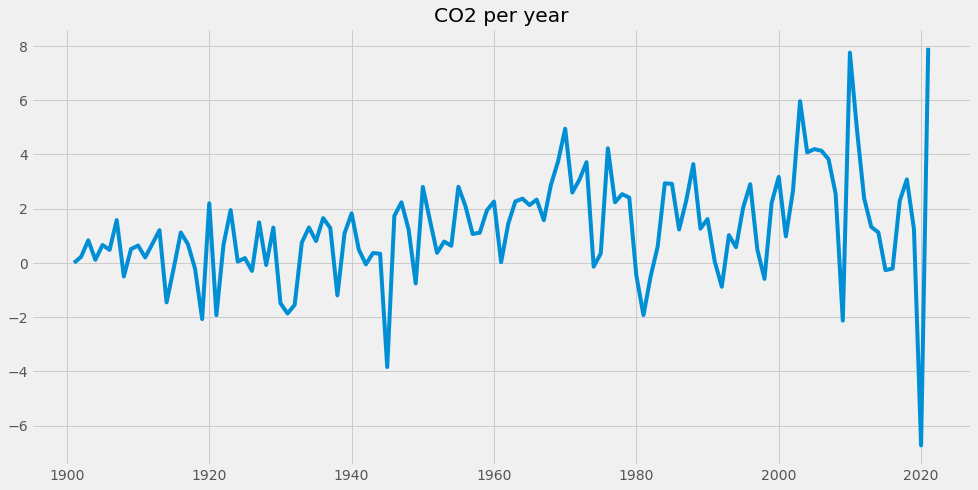

In [20]:
#ploting the new diff() series

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(co2_f_diff['t_diff_1'])
plt.title("CO2 per year")
plt.show()


In [113]:
# #Function to know stacionality with the new t_diff_2  series.
Prueba_Dickey_Fuller(co2_f_diff["t_diff_2"],"t_diff_2")

Resultados de la prueba de Dickey-Fuller para columna: t_diff_2
Test Statistic                         -5.520286
p-value                                 0.000002
No Lags Used                            9.000000
Número de observaciones utilizadas    111.000000
Critical Value (1%)                    -3.490683
Critical Value (5%)                    -2.887952
Critical Value (10%)                   -2.580857
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios (Stationary)


Decompose the series to know wich model can use and verifiy if has seasonality.

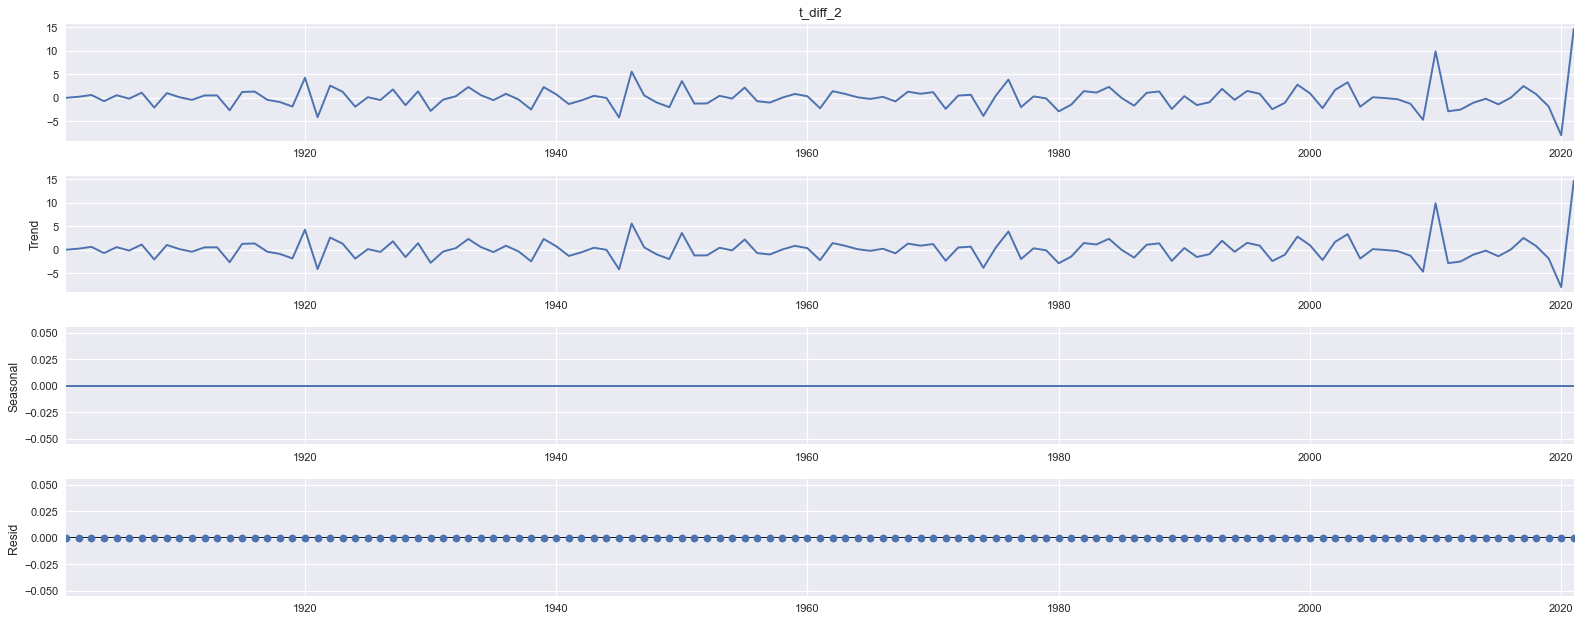

In [101]:
result = seasonal_decompose(co2_f_diff['t_diff_2'], model='add',extrapolate_trend='freq')
result.plot()
plt.show()

### Use ARIMA model might not be reliable in this case, however we will use it to see and compare with other models

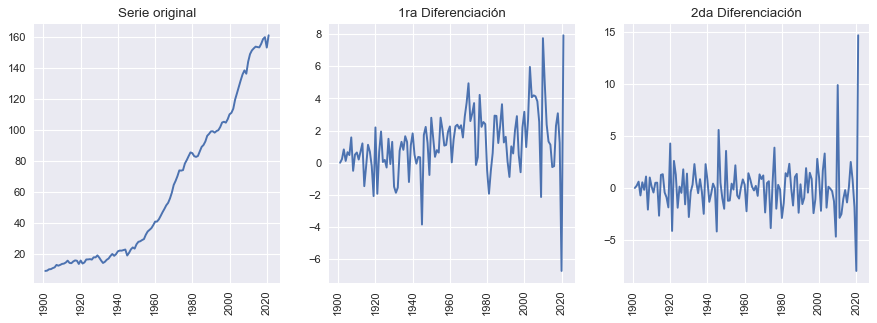

In [63]:
#ploting the original and diferenced series.

plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':80})

# Original Series
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(co2_f['total']) 
axes[0].set_title('Serie original')

# 1st Diff
axes[1].plot(co2_f_diff['t_diff_1'])
axes[1].set_title('1ra Diferenciación')

# 2th Diff
axes[2].plot(co2_f_diff['t_diff_2'])
axes[2].set_title('2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

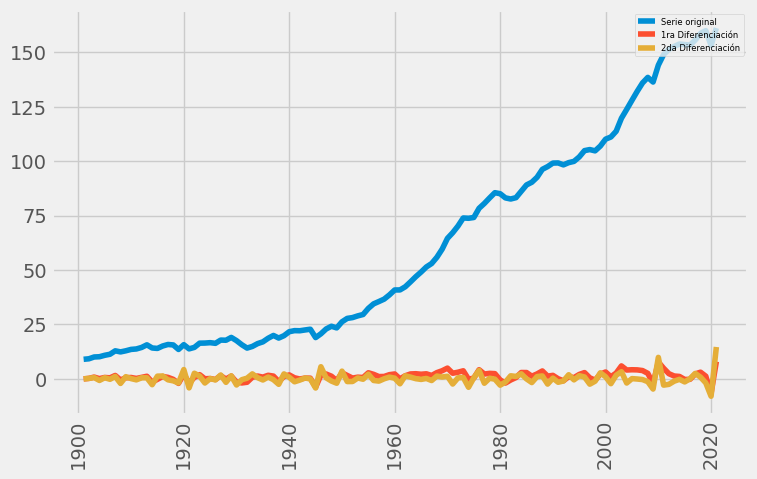

In [24]:
#ploting the original and diferenced series.
fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=100, sharex=True)

axes.plot(co2_f_diff['total'], label='Serie original')
axes.plot(co2_f_diff['t_diff_1'], label='1ra Diferenciación')
axes.plot(co2_f_diff['t_diff_2'], label='2da Diferenciación')
axes.legend(loc='upper right', fontsize=6)
plt.xticks(rotation=90)

plt.show()

From the graph below we can get "p" and "q" values.

The ACF function is used to identify the moving average (MA) process in an ARIMA model; while the PACF function is used to identify the values of the autoregressive (AR) part of the process.

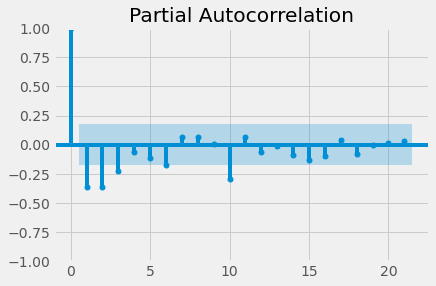

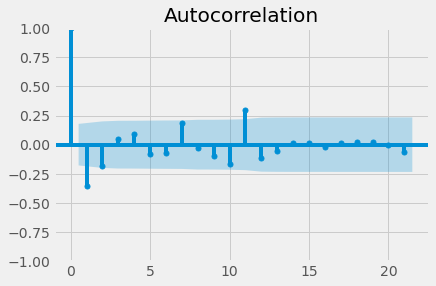

In [25]:
# we can see in the graphs p = 10 and q= 12
plot_pacf(co2_f_diff['t_diff_2']);
plot_acf(co2_f_diff['t_diff_2']);

In [26]:
#Func to get the better combination in ARIMA model.
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

We make an iteration to get the best combination and get the best AIC.

Its result a Df with p,d,q combination and the AIC value.

In [27]:
ps = range(0, 10)
d = 1
qs = range(0, 12)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=co2_f['total'])

result_df

  0%|          | 0/120 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(7, 1, 8)",499.609044
1,"(8, 1, 8)",500.092124
2,"(7, 1, 3)",500.310497
3,"(3, 1, 4)",500.913186
4,"(7, 1, 9)",500.953325
...,...,...
115,"(0, 1, 3)",525.632015
116,"(1, 1, 0)",527.567111
117,"(0, 1, 2)",533.211191
118,"(0, 1, 1)",533.751466


## Train, Validation and Test.
Split from DF to train and evaluate models.

This split going to be used in all other Models.

In [78]:
# Separación datos train-evaluation-test
# ==============================================================================
fin_train = '1959-01-01'
fin_validacion = '2001-01-01'
datos_train = co2_f.loc[: fin_train, :]
datos_val   = co2_f.loc[fin_train:fin_validacion, :]
datos_test  = co2_f.loc[fin_validacion:, :]
test=datos_test.copy()
train = co2_f[:len(co2_f)-20]

print(f"Fechas datos_train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas datos_val  : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas datos_test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")

Fechas datos_train : 1901-01-01 00:00:00 --- 1959-01-01 00:00:00  (n=59)
Fechas datos_val  : 1959-01-01 00:00:00 --- 2001-01-01 00:00:00  (n=43)
Fechas datos_test  : 2001-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=21)
Fechas train : 1901-01-01 00:00:00 --- 2001-01-01 00:00:00  (n=101)


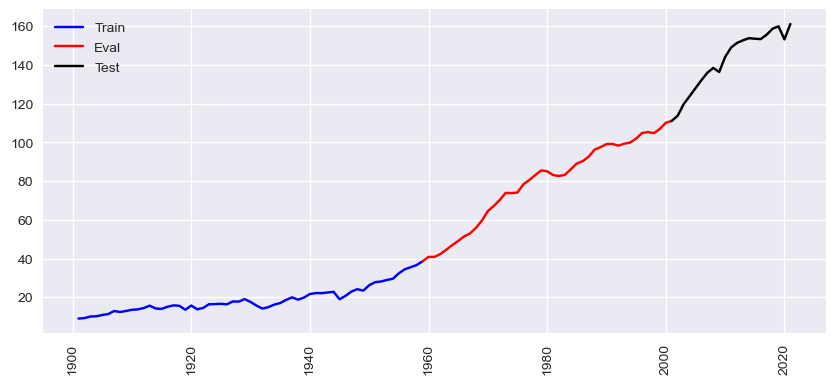

In [83]:
#ploting train-evaluation-test sets
fig, axes = plt.subplots(1, 1, figsize=(9,4), dpi=100, sharex=True)

axes.plot(datos_train['total'], label='Train', color="blue")
axes.plot(datos_val['total'], label='Eval', color="red")
axes.plot(datos_test['total'], label='Test', color="black")
axes.legend(loc='upper left', fontsize=10)
plt.xticks(rotation=90)

plt.show()

## ARIMA
we create the ARIMA model and get the summary

In [29]:
#Creating the model with the p,d,q values of cell 27
arima_model = sm.tsa.arima.ARIMA(train, order=(6, 1, 8)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                  101
Model:                 ARIMA(6, 1, 8)   Log Likelihood                -169.279
Date:                Thu, 02 Feb 2023   AIC                            368.558
Time:                        11:07:01   BIC                            407.636
Sample:                    01-01-1901   HQIC                           384.373
                         - 01-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0363      1.611      0.023      0.982      -3.121       3.194
ar.L2          0.1726      0.305      0.566      0.571      -0.425       0.770
ar.L3         -0.1059      0.495     -0.214      0.8

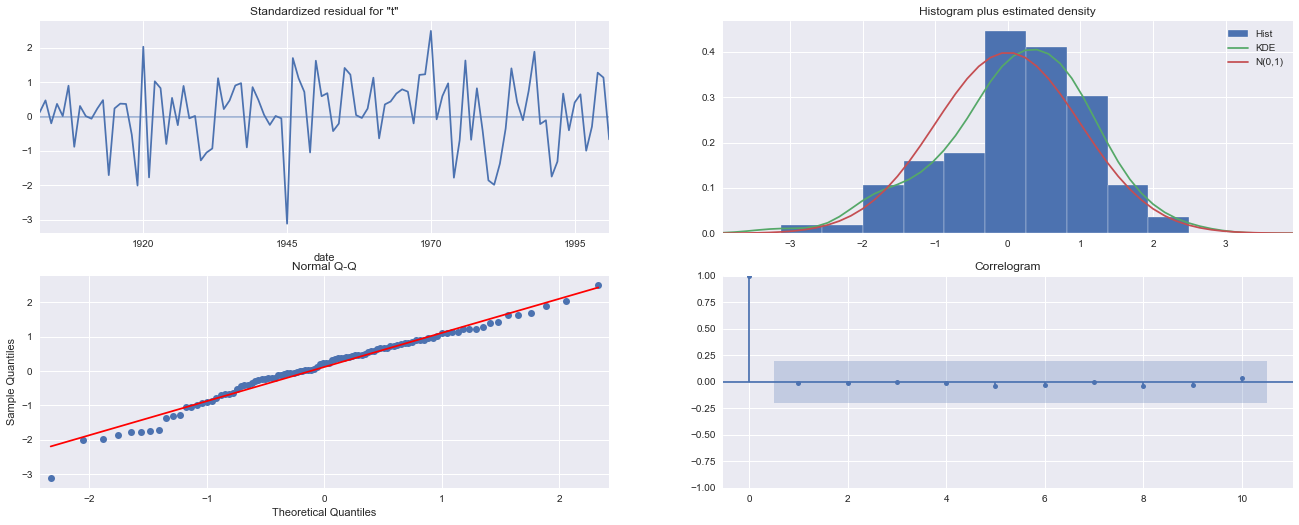

In [30]:
#verify the disgnostig model to evaluate
plt.style.use('seaborn')
arima_model.plot_diagnostics(figsize=(20,8))
plt.show()

###  Interpreting plot diagnostics

*Upper left*: the residual errors appear to fluctuate around a mean of zero and have a uniform variance.

*Upper rigth*: The KDE plot suggest a normal distribution with mean zero.

*Bottom left*: All points must be perfectly aligned with the red line. Any significant deviation would imply that the distribution is skewed.

*Bottom rigth*: The correlogram, also known as the ACF plot, shows that the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors that is not explained in the model. So you will need to look for more X's (predictors) in the model.

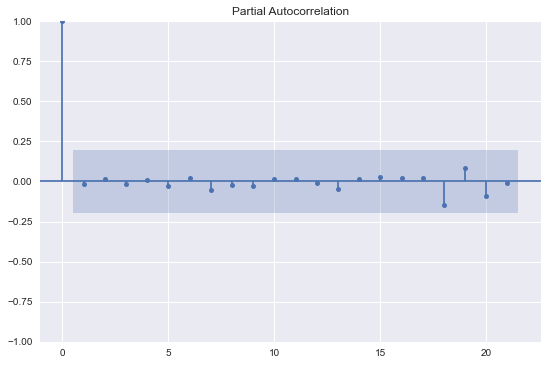

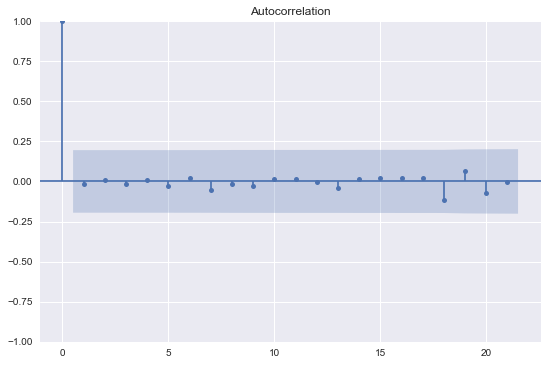

In [31]:
plot_pacf(arima_model.resid);
plot_acf(arima_model.resid);

In [32]:
# After train the model, we use the test split to predict.
arima_pred = arima_model.predict(start = '2001-01-01', end = '2021-01-01', typ = 'levels')
arima_pred

2001-01-01    111.967991
2002-01-01    112.995938
2003-01-01    114.088386
2004-01-01    114.244742
2005-01-01    115.054851
2006-01-01    116.942460
2007-01-01    118.951700
2008-01-01    119.930231
2009-01-01    120.526127
2010-01-01    121.203341
2011-01-01    122.644917
2012-01-01    124.296575
2013-01-01    125.488625
2014-01-01    126.241625
2015-01-01    126.948204
2016-01-01    128.084593
2017-01-01    129.466447
2018-01-01    130.667376
2019-01-01    131.532971
2020-01-01    132.280016
2021-01-01    133.241435
Freq: AS-JAN, Name: predicted_mean, dtype: float64

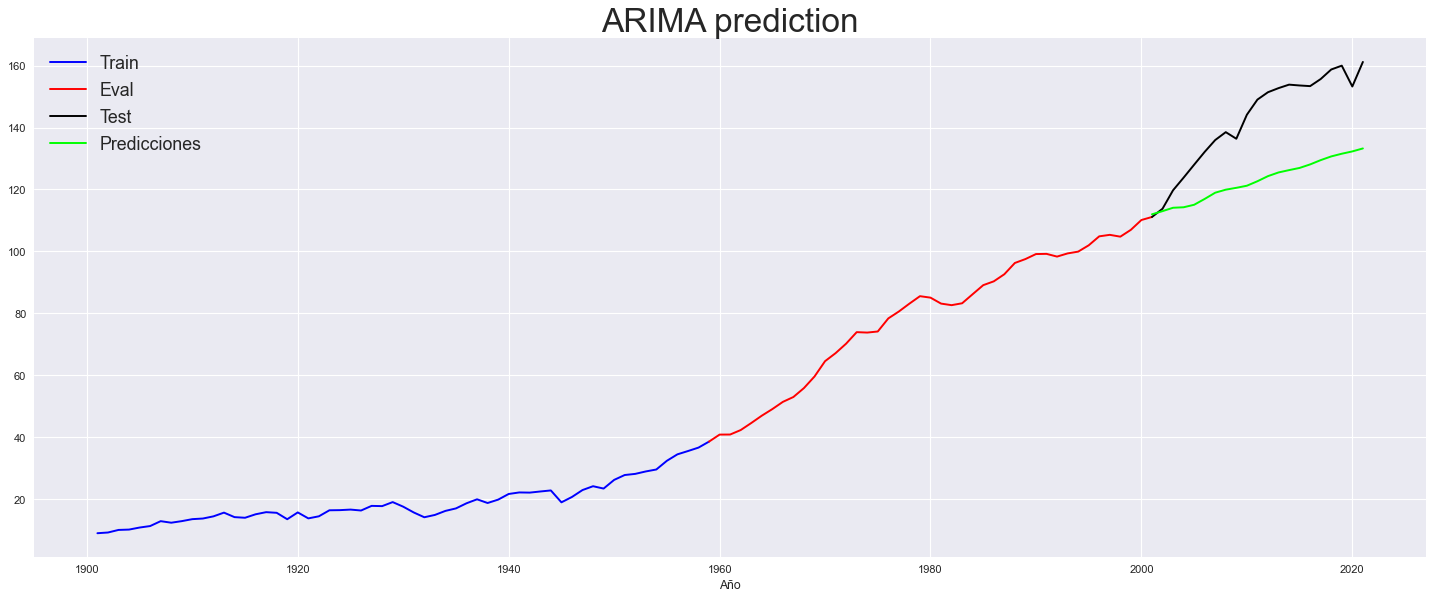

In [114]:
# Plotting the real value and prediction
# ==============================================================================
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_train,color="blue" ,label="Train")
plt.plot(datos_val,color="red" ,label="Eval")
plt.plot(datos_test,color="black" ,label="Test")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("ARIMA prediction", fontsize=30);
plt.xlabel('Año')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

we create a function to evaluate the performance model, using some metric as MSE, MAE, etc

In [35]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    

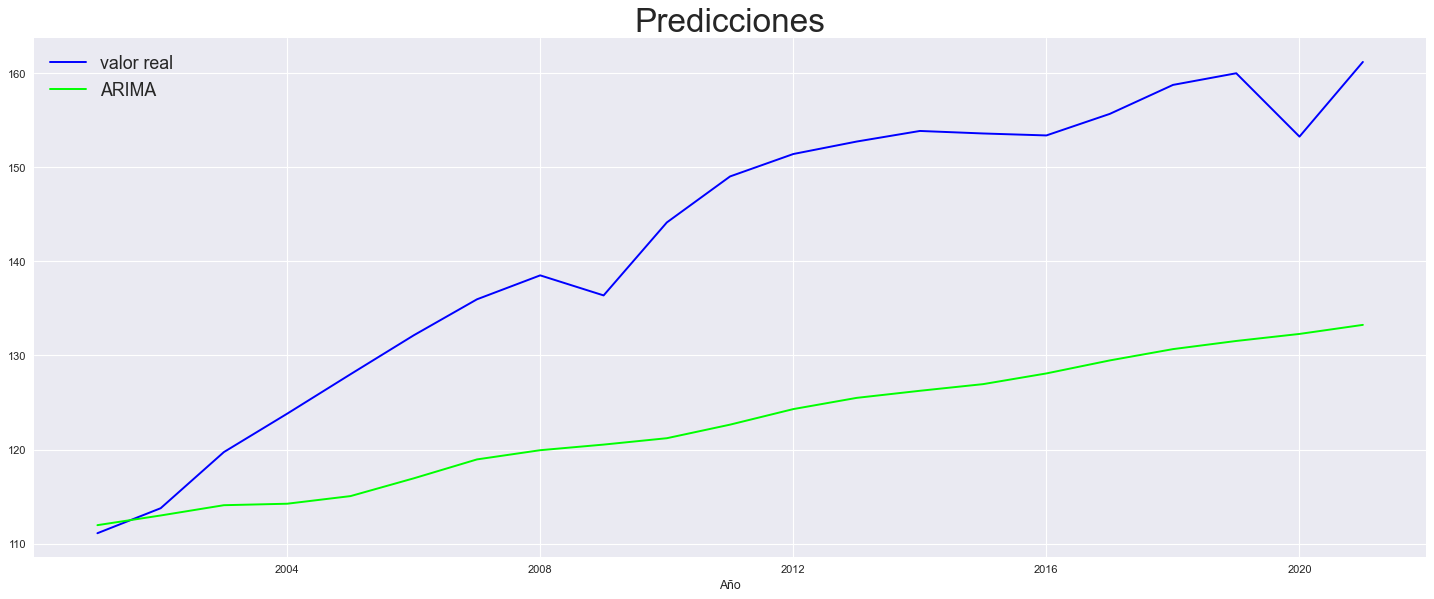

In [68]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_test,color="blue" ,label="valor real")
plt.plot(arima_pred, color="lime", label="ARIMA")
plt.title("Predicciones", fontsize=30);
plt.xlabel('Año')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [37]:
#Using the func to evauate the performance
evaluacion_metrica(datos_test, arima_pred)

Evaluation metric results:-
MSE is : 462.5944681010298
MAE is : 19.574562246345565
RMSE is : 21.508009394200798
MAPE is : 14.983300171538803
R2 is : -0.9849997669710715



we merge the real and predicted values into a DF to compare with other models

In [38]:
datos_test['ARIMA'] = arima_pred
datos_test

,total,ARIMA
date,,
2001-01-01,111.112542,111.967991
2002-01-01,113.766988,112.995938
2003-01-01,119.730454,114.088386
2004-01-01,123.805020,114.244742
2005-01-01,127.999707,115.054851
2006-01-01,132.134462,116.942460
2007-01-01,135.957075,118.951700
2008-01-01,138.501267,119.930231
2009-01-01,136.371299,120.526127


# RandomForest 

In [39]:
#--Libraries to install--
#pip install xgboost
#pip install lightgbm
#pip install catboost
#pip install skforecast

In [40]:
# Libraries to Forecasting
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [41]:
# Creating forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 25
             )

forecaster.fit(y=train['total'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1901-01-01 00:00:00'), Timestamp('2001-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: AS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-02 11:07:04 
Last fit date: 2023-02-02 11:07:04 
Skforecast versio

In [42]:
#Predicction
steps = 10
predicciones = forecaster.predict(steps=steps)
predicciones.head(10
                 )

2002-01-01    109.742021
2003-01-01    109.805077
2004-01-01    109.708250
2005-01-01    109.756160
2006-01-01    109.756160
2007-01-01    109.756160
2008-01-01    109.756160
2009-01-01    109.756160
2010-01-01    109.756160
2011-01-01    109.756160
Freq: AS-JAN, Name: pred, dtype: float64

## Tuning RF
Es importante que, en la búsqueda de hiperparámetros, no se utilicen los datos de test, de lo contrario podrían aparecer problemas de sobreajuste del modelo. Con este objetivo, se realiza una búsqueda en la que, con cada combinación de hiperparámetros y lags:

1) Se entrena el modelo con los datos de entrenamiento.

2) Se evalúa el modelo con los datos de validación mediante backtesting sin reentrenamiento.

3) Se identifica la combinación de hiperparámetros y lags con los que se consigue menor error.

4) Se entrena el modelo con la mejor combinación encontrada, esta vez con todos los datos de entrenamiento y validación.

In [43]:
# Grid search de hiperparámetros
# ==============================================================================
# used data_val to get the best parameters

steps = 5
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid_rf = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = co2_f.loc[:fin_validacion, 'total'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )



Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:00<00:00, 30.09s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 43.592666615581095



In [44]:
# Grid Search result
# ==============================================================================
resultados_grid_rf.head(10)

,lags,params,mean_squared_error,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",43.592667,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",43.745741,5,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",44.019859,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",44.169665,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",45.912998,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",46.529192,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",46.942941,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",47.246507,5,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",55.452993,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",56.485127,3,100


In [45]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=train['total'])

In [46]:
# Predicciones
# ==============================================================================
predicciones_rf = forecaster.predict(steps=21)

In [47]:
predicciones_rf

2002-01-01    109.372839
2003-01-01    109.778756
2004-01-01    109.778756
2005-01-01    109.778756
2006-01-01    109.778756
2007-01-01    109.778756
2008-01-01    109.778756
2009-01-01    109.778756
2010-01-01    109.778756
2011-01-01    109.778756
2012-01-01    109.778756
2013-01-01    109.778756
2014-01-01    109.778756
2015-01-01    109.778756
2016-01-01    109.778756
2017-01-01    109.778756
2018-01-01    109.778756
2019-01-01    109.778756
2020-01-01    109.778756
2021-01-01    109.778756
2022-01-01    109.778756
Freq: AS-JAN, Name: pred, dtype: float64

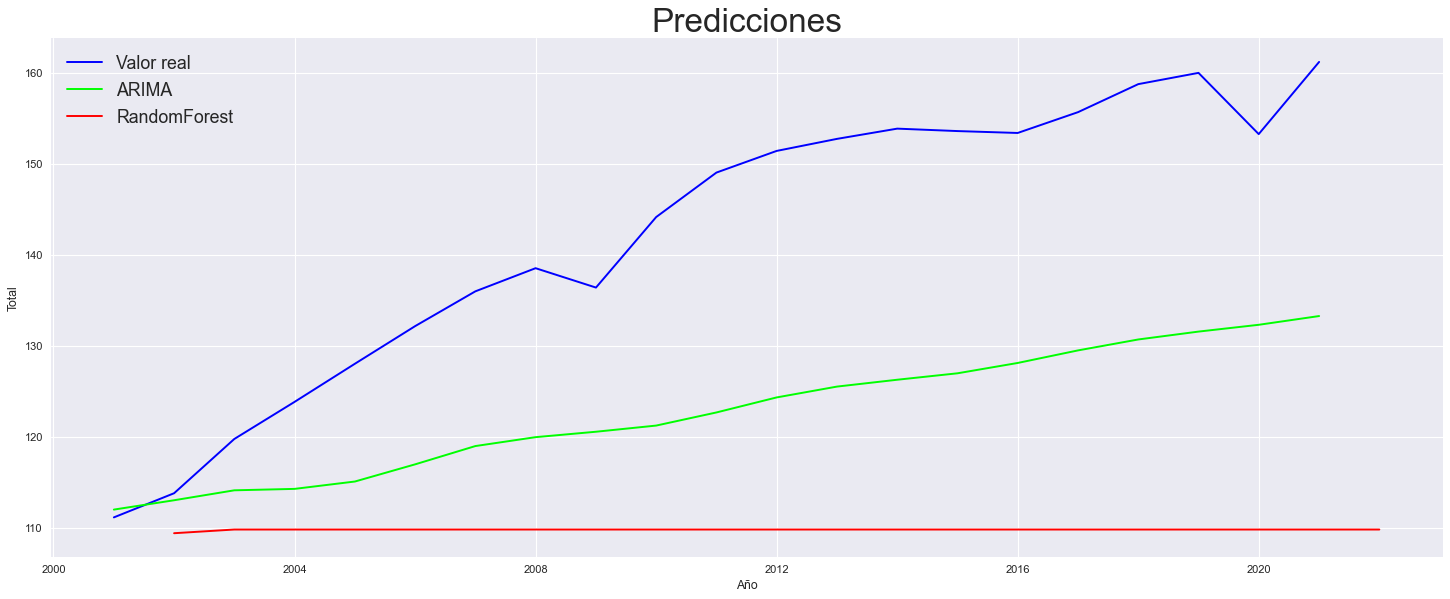

In [69]:
#Ploting the Random forest prediction
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_test,color="blue" ,label="Valor real")
plt.plot(arima_pred, color="lime", label="ARIMA")
plt.plot(predicciones_rf, color = "red", label="RandomForest")
plt.title("Predicciones", fontsize=30);
plt.xlabel('Año')
plt.ylabel('Total')
plt.legend( fontsize=16);
plt.show();


### Backtesting
Once the best combination of hyperparameters has been identified using the validation data, the predictive capacity of the model is evaluated with the test set. The backtesting_forecaster function is called

In [49]:
# Backtesting
# ==============================================================================
steps = 1
n_backtesting = 7*3 # Se separan para el backtest

metrica, predicciones_backtest_rf = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = co2_f['total'],
                                    initial_train_size = len(co2_f) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 100
Number of observations used for backtesting: 21
    Number of folds: 21
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   1901-01-01 00:00:00 -- 2000-01-01 00:00:00  (n=100)
    Validation: 2001-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=1)
Data partition in fold: 1
    Training:   1901-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=101)
    Validation: 2002-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=1)
Data partition in fold: 2
    Training:   1901-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=102)
    Validation: 2003-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=1)
Data partition in fold: 3
    Training:   1901-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=103)
    Validation: 2004-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=1)
Data partition in fold: 4
    Training:   1901-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=104)
    Validation: 2005-01-01 00:00:00 -

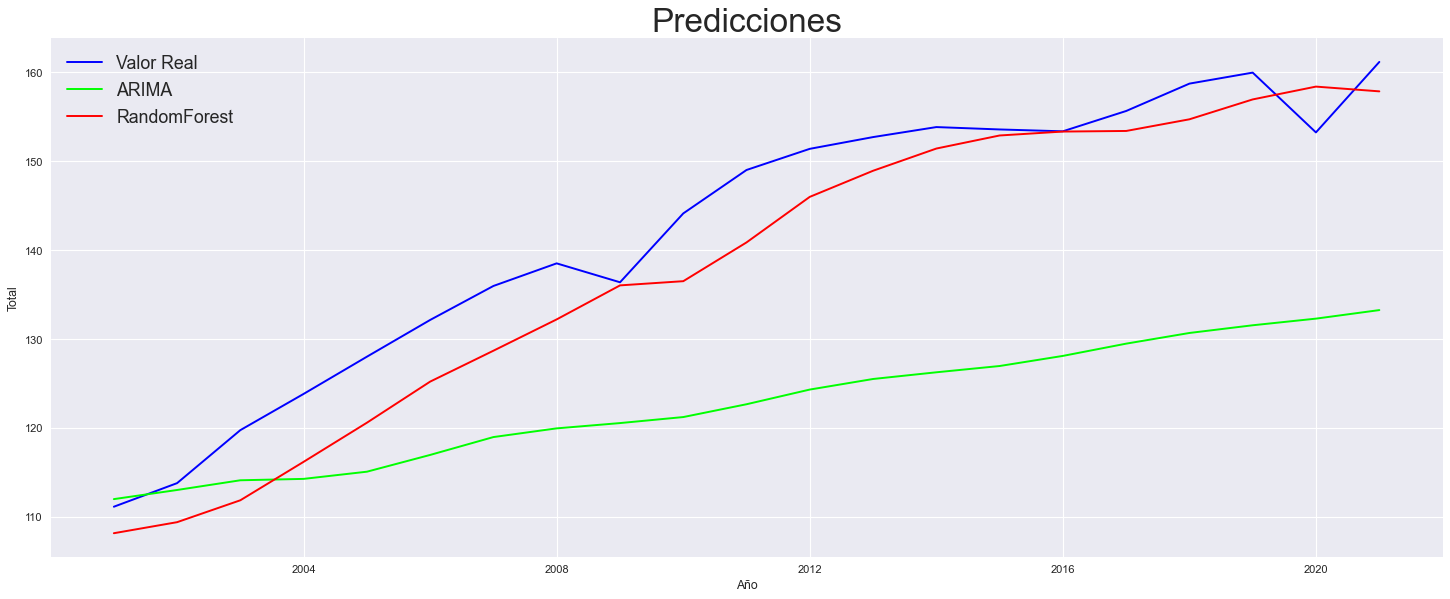

In [70]:
#ploting random forest prediction after baacktesting
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_test,color="blue" ,label="Valor Real")
plt.plot(arima_pred, color="lime", label="ARIMA")
plt.plot(predicciones_backtest_rf, color = "red", label="RandomForest")
plt.title("Predicciones", fontsize=30);
plt.xlabel('Año')
plt.ylabel('Total')
plt.legend( fontsize=16);
plt.show();

In [51]:
#we merge the real and predicted values into a DF to compare with other models
datos_test["RForest"] = predicciones_backtest_rf
datos_test

,total,ARIMA,RForest
date,,,
2001-01-01,111.112542,111.967991,108.130354
2002-01-01,113.766988,112.995938,109.372839
2003-01-01,119.730454,114.088386,111.837117
2004-01-01,123.805020,114.244742,116.160997
2005-01-01,127.999707,115.054851,120.570585
2006-01-01,132.134462,116.942460,125.194400
2007-01-01,135.957075,118.951700,128.670069
2008-01-01,138.501267,119.930231,132.193200
2009-01-01,136.371299,120.526127,136.023524


In [52]:
evaluacion_metrica(test, predicciones_backtest_rf)

Evaluation metric results:-
MSE is : 27.98389052746677
MAE is : 4.62258775895305
RMSE is : 5.289980201046765
MAPE is : 3.3650550923533826
R2 is : 0.8799207080793843



## XGBoost

In [53]:
# Crear forecaster
# ==============================================================================
forecaster_xg = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, n_jobs=-1),
                lags = 24
             )

forecaster_xg

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous va

In [91]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [10, 20]


resultados_grid_xg = grid_search_forecaster(
        forecaster         = forecaster_xg,
        y                  = co2_f.loc[:fin_validacion, 'total'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 5,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 2169.091239388244



In [86]:
# Grid Search Results
# ==============================================================================
resultados_grid_xg.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2169.091239,0.1,3.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2169.091556,0.1,10.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2169.094405,0.1,10.0,500.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2169.094721,0.1,5.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2169.094721,0.1,5.0,500.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2170.306795,0.1,3.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2181.912657,0.1,10.0,100.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2181.912975,0.1,5.0,100.0
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2181.912975,0.1,3.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2181.956505,0.1,5.0,100.0


In [87]:
# Creating and training forecaster with best hiperparameters
# ==============================================================================
regressor = XGBRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster_xg = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster_xg.fit(y=train['total'])

In [95]:
# Backtesting
# ==============================================================================
steps = 1
n_backtesting = 7*3 # Se separan para el backtest

metrica, predicciones_backtest_xg = backtesting_forecaster(
                                    forecaster         = forecaster_xg,
                                    y                  = co2_f['total'],
                                    initial_train_size = len(co2_f) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 100
Number of observations used for backtesting: 21
    Number of folds: 21
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   1901-01-01 00:00:00 -- 2000-01-01 00:00:00  (n=100)
    Validation: 2001-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=1)
Data partition in fold: 1
    Training:   1901-01-01 00:00:00 -- 2001-01-01 00:00:00  (n=101)
    Validation: 2002-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=1)
Data partition in fold: 2
    Training:   1901-01-01 00:00:00 -- 2002-01-01 00:00:00  (n=102)
    Validation: 2003-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=1)
Data partition in fold: 3
    Training:   1901-01-01 00:00:00 -- 2003-01-01 00:00:00  (n=103)
    Validation: 2004-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=1)
Data partition in fold: 4
    Training:   1901-01-01 00:00:00 -- 2004-01-01 00:00:00  (n=104)
    Validation: 2005-01-01 00:00:00 -

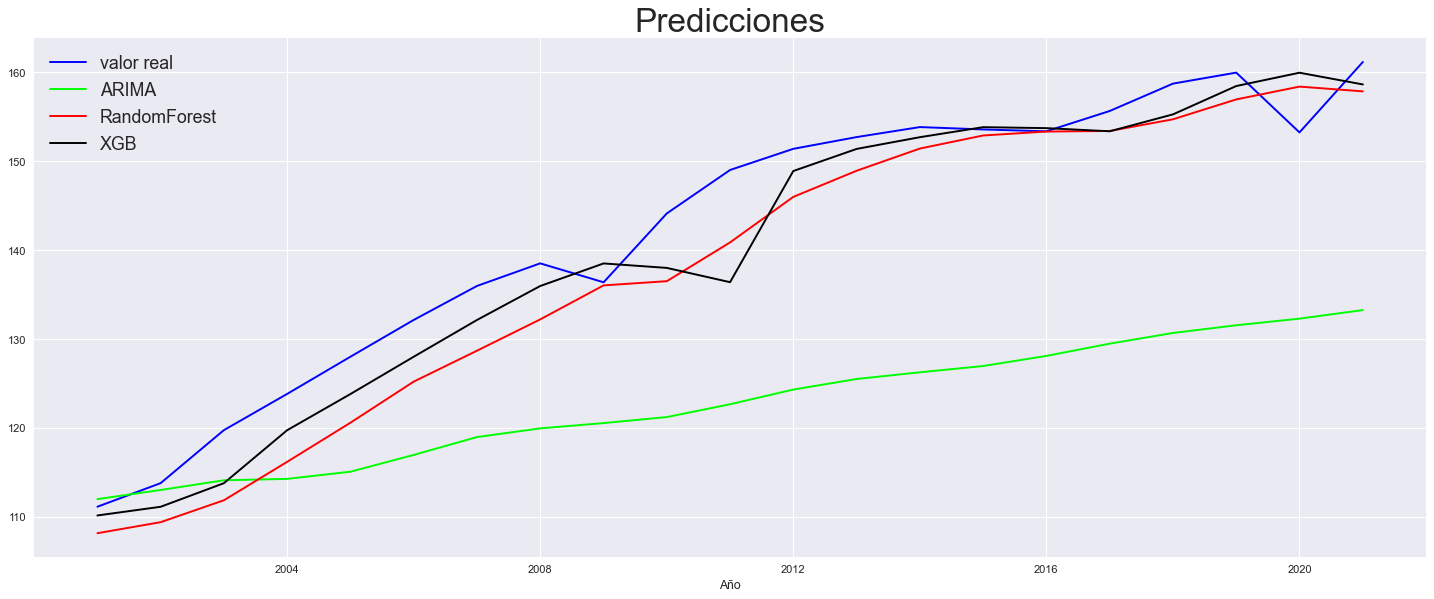

In [96]:
#ploting predictions
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_test,color="blue" ,label="valor real")
plt.plot(arima_pred, color="lime", label="ARIMA")
plt.plot(predicciones_backtest_rf, color = "red", label="RandomForest")
plt.plot(predicciones_backtest_xg, color = "black", label="XGB")
plt.title("Predicciones", fontsize=30);
plt.xlabel('Año')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

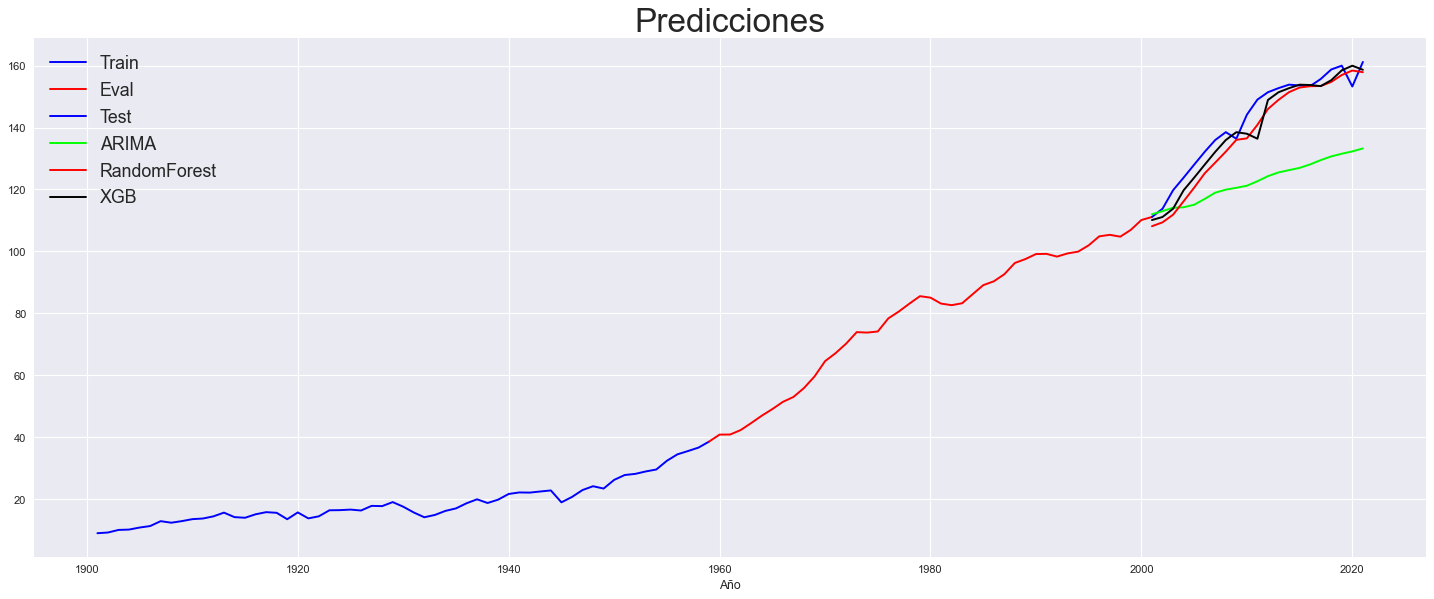

In [106]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(datos_train,color="blue" ,label="Train")
plt.plot(datos_val,color="red" ,label="Eval")
plt.plot(datos_test,color="blue" ,label="Test")
plt.plot(arima_pred, color="lime", label="ARIMA")
plt.plot(predicciones_backtest_rf, color = "red", label="RandomForest")
plt.plot(predicciones_backtest_xg, color = "black", label="XGB")
plt.title("Predicciones", fontsize=30);
plt.xlabel('Año')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show()

In [61]:
datos_test["XGB"] = predicciones_backtest_xg 
datos_test

,total,ARIMA,RForest,XGB
date,,,,
2001-01-01,111.112542,111.967991,108.130354,110.133003
2002-01-01,113.766988,112.995938,109.372839,111.111229
2003-01-01,119.730454,114.088386,111.837117,113.765625
2004-01-01,123.805020,114.244742,116.160997,119.729202
2005-01-01,127.999707,115.054851,120.570585,123.803780
2006-01-01,132.134462,116.942460,125.194400,127.998436
2007-01-01,135.957075,118.951700,128.670069,132.133240
2008-01-01,138.501267,119.930231,132.193200,135.955750
2009-01-01,136.371299,120.526127,136.023524,138.500031
